## Introdução e Objetivos

A pandemia da Covid-19 teve seu início ao final de 2019, com um surto causado pelo Sars-Cov-2 na província de Wuhan, na China. Pouco mais de dois anos depois, ainda estamos lidando com esse cenário caótico através de mudanças no nosso cotidiano, como o uso de máscaras, distanciamento social e higienização constante de mãos e do ambiente, além de termos que nos adaptar ao surgimento de novas variantes enquanto corremos no avanço das vacinas.</br>
Atualmente, a variante mais importante é a Ômicron, que, apesar de caracterizada por uma baixa taxa de mortalidade, possui uma alta taxa de infecção, gerando uma grande quantia de infectados, e, por consequência, uma quantidade de mortes que não pode ser ignorada. Estimar o comportamento de um vírus é uma forma de prevenção e possibilita evitar uma tragédia ainda maior, ao mesmo tempo que nos trás passos para um retorno gradiente às nossas vidas normais.</br>
Neste projeto, tentaremos explicar a situação atual da Covid-19 em Pernambuco, bem como prever o estado da pandemia ao final do mês de julho. Para isso, usaremos conhecimentos de estatística e cálculo para estabelecer um modelo epidemiológico razoável, utilizando de bibliotecas da linguagem Python (NumPy, SciPy) para resolver ODEs e assim conseguir previsões, representadas graficamente com auxílio da Matplotlib. Por consequência, será uma importante prática de modelagem matemática para um problema do mundo real.

## Metodologia

Número de casos (01/02/2021): 9286241</br>
Número de mortos: 225143

Data was extracted considering the first day analyzed, that is, 1st February 2021 (01/02/2021). </br>
Where $IFR$ is the Infection Fatality Ratio, calculated from data in [1] using the formula in [2]. </br>
The mean incubation period $\tau$, mean time for recover $\tau_r$ and mean time for death $\tau_d$ were obtained from [3]. </br>
The initial infected count was extracted from [4], considering that the actively infected population for that day was the amount of confirmed cases until then subtracted by death and recovery counts. Considering a small enough superposition, this data is taken as sufficiently accurate. 

In [50]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [51]:
# Total population, N.
N = 9674793

# Initial number of infected, recovered, exposed and dead individuals (01/02/2021)
I0, R0, E0, D0, V0 = 21452, 0, 0, 0, 0

# Everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0 - E0 - D0 - V0

# Contact rate for infected and exposed individuals
beta_I, beta_E = 0.2, 0.1

# Infection fatality ratio
ifr = 0.0242

# Average time for incubation, recovery and death
tau = 5
tau_r, tau_d = 14, tau + 15

# Mean recovery and death rates
gamma = (1 - ifr) / tau_r
mu =  ifr / tau_d

# A grid of time points (in days) for the first time period (01/02/2021 - 31/01/2022)
t = np.linspace(0, 364, 365)

# A grid of time points (in days) for the second time period (01/02/2022 - 31/07/2022)
t2 = np.linspace(365, 365+180, 181)

In [ ]:
# Vaccination rate
# Dia inicial: 18/01/2021
def vaccination(t):
    if t <= 100: # estimação de quando 100% da população vai ser vacinada
        return 0
    return 1

In [52]:
def deriv(y, t):
    S, I, R, E, D, V = y
    dSdt = -beta_I*S*I/N - beta_E*S*E/N - vaccination(t) * S
    dEdt = beta_I*S*I/N + beta_E*S*E/N - E/tau
    dIdt = E/tau - (gamma + mu)*I
    dRdt = gamma * I
    dDdt = mu * I
    dVdt = vaccination(t) * S
    return dSdt, dIdt, dRdt, dEdt, dDdt, dVdt

In [53]:
# Initial conditions vector
y0 = S0, I0, R0, E0, D0, V0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t)
S, I, R, E, D, V = ret.T

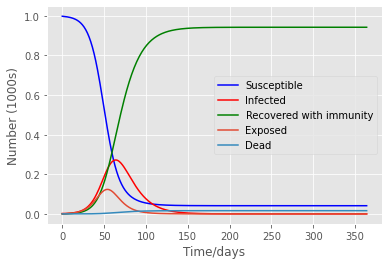

In [54]:
plt.plot(t, S/N, 'b', label='Susceptible')
plt.plot(t, I/N, 'r', label='Infected')
plt.plot(t, R/N, 'g', label='Recovered with immunity')
plt.plot(t, E/N, label='Exposed')
plt.plot(t, D/N, label='Dead')
plt.xlabel('Time/days')
plt.ylabel('Number (1000s)')
plt.legend()
plt.show()

## Referências
[1] [Vacinômetro - Brasil](https://www.worldometers.info/coronavirus/country/brazil/)</br>
[2] [WHO - Estimating mortality from COVID-19](https://www.who.int/news-room/commentaries/detail/estimating-mortality-from-covid-19) </br>
[3] [Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data](https://pubmed.ncbi.nlm.nih.gov/32079150/) </br>
[4] [Painel de casos de doença pelo coronavírus 2019 (COVID-19) em Pernambuco, no Brasil e no Mundo.](https://dados.seplag.pe.gov.br/apps/corona.html#geral) </br>
[5] []() </br>
[6] []() </br>
